In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model

In [15]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [6]:
model = InceptionV3(weights='imagenet')
bottleneck_model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# Consolidate Data

In [275]:
merchant_dirs = ['f21_images', 'zara_images', 'hm_images']
total_files = [x + "/" + y for x in merchant_dirs for y in os.listdir(x) if '.jpg' in y]
total_files[0:3]

['f21_images/image_1000257241_02.jpg',
 'f21_images/image_1000257241_02_2.jpg',
 'f21_images/image_1000266556_01.jpg']

In [278]:
from shutil import copyfile
for i, file in enumerate(total_files):
    dest = 'all_products/{}.jpg'.format(i)
    copyfile(file, dest)

# Generate Features

In [286]:
for id_name in [p.split('.')[0] for p in os.listdir("all_products")]:
    if(id_name ==""): continue
    img_path = 'all_products/{}.jpg'.format(id_name)
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)

    features = bottleneck_model.predict(x)
    final_features = np.append([float(id_name)], features).reshape(1,-1)
    final_features.dump('features/{}.pkl'.format(id_name))

In [288]:
all_features = []
for pkl in os.listdir('features'):
    if ".pkl" not in pkl: continue
    all_features.append(np.load('features/' +pkl))

In [289]:
np.array(all_features).dump('all_features.pkl')

# Feature Clustering

In [290]:
features = np.load('all_features.pkl')
image_features = features[:,0,1:]
image_ids = features[:,0,0]

In [292]:
print(image_features.shape)
print(image_ids[50:100])

(5955, 2048)
[1042. 1043. 1044. 1045. 1046. 1047. 1048. 1049.  105. 1050. 1051. 1052.
 1053. 1054. 1055. 1056. 1057. 1058. 1059.  106. 1060. 1061. 1062. 1063.
 1064. 1065. 1066. 1067. 1068. 1069.  107. 1070. 1071. 1072. 1073. 1074.
 1075. 1076. 1077. 1078. 1079.  108. 1080. 1081. 1082. 1083. 1084. 1085.
 1086. 1087.]


In [325]:
from sklearn.decomposition import PCA
from keras.models import load_model

pca = PCA(n_components=100)
principalComponents = pca.fit(image_features)
reduced_data_pca = principalComponents.transform(image_features)

model = load_model('models/all_encoder.h5')
reduced_data_auto = model.predict(image_features)

print(reduced_data.shape)

/Users/muhammedanwar/anaconda/envs/tensorflow-cpu/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(2010, 128)


In [326]:
import numpy as np
from sklearn.neighbors import KDTree
tree_pca = KDTree(reduced_data_pca, leaf_size=2) 
tree_auto = KDTree(reduced_data_auto, leaf_size=2)

In [351]:
img_path = 'rui_test.JPG'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

sanjana_features = bottleneck_model.predict(x)
reduced_sanjana_auto = model.predict(sanjana_features) 
reduced_sanjana_pca = principalComponents.transform(sanjana_features)

In [352]:
k = 20
dist_pca, ind_pca = tree_pca.query([reduced_sanjana_pca[0]], k=k) 
dist_auto, ind_auto = tree_auto.query([reduced_sanjana_auto[0]], k=k) 

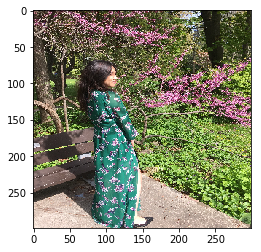

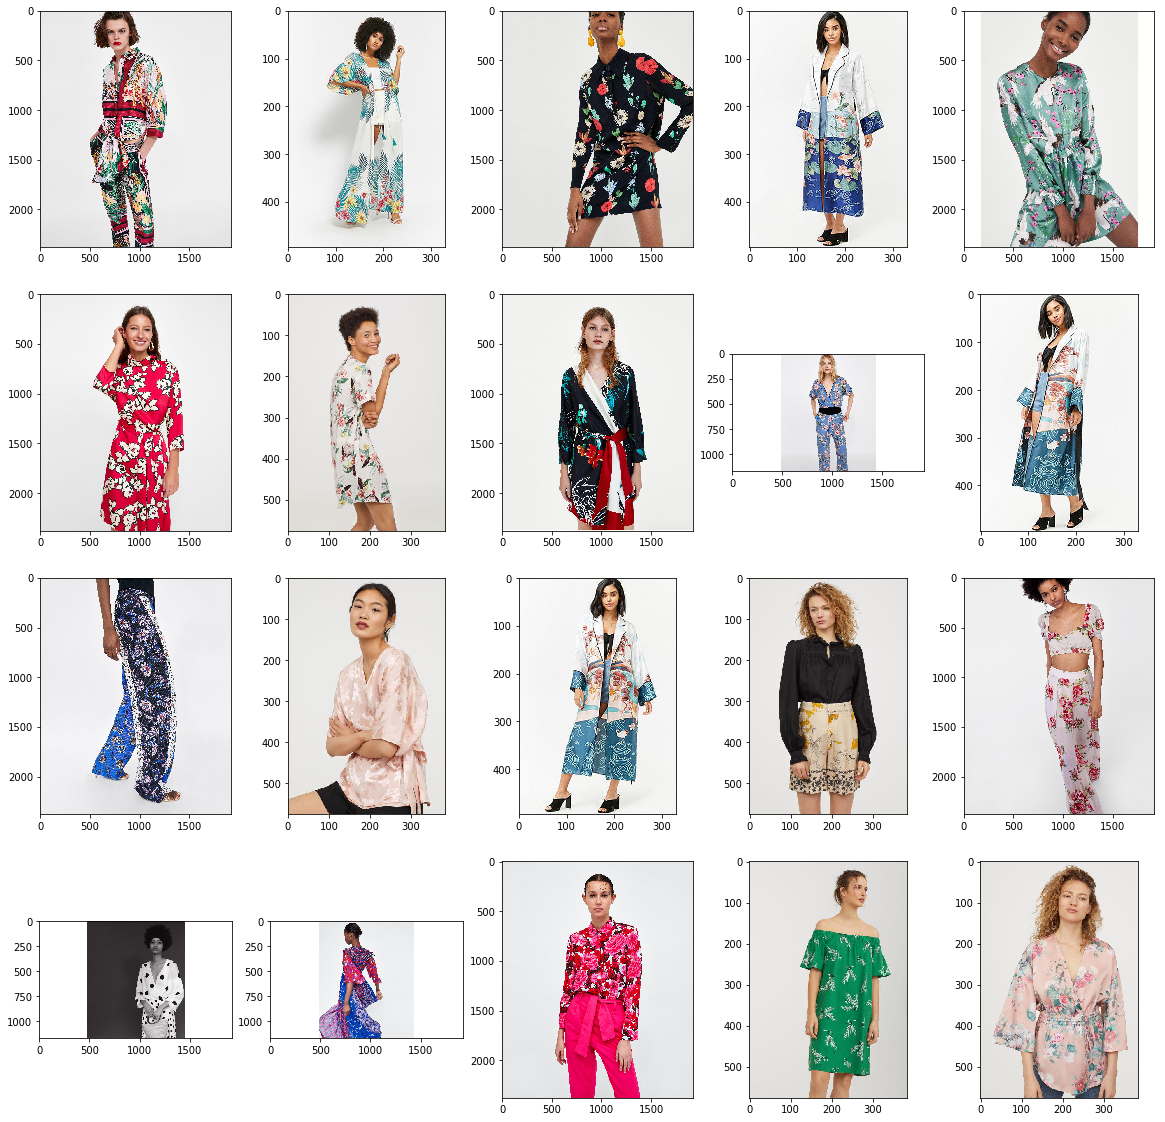

In [353]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math

plt.imshow(img)

w=20
h=20
cols = 5
fig=plt.figure(figsize=(w, h))
for i, file_id in enumerate([str(int(f)) for f in list(image_ids[ind_pca][0])]):
    rec_img=mpimg.imread('all_products/' + file_id + ".jpg")
    sub_fig = fig.add_subplot(math.ceil(k/cols), cols, i+1)
    sub_fig.imshow(rec_img)
    


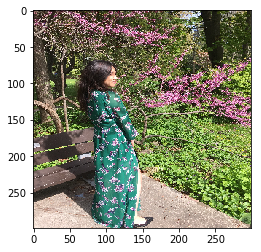

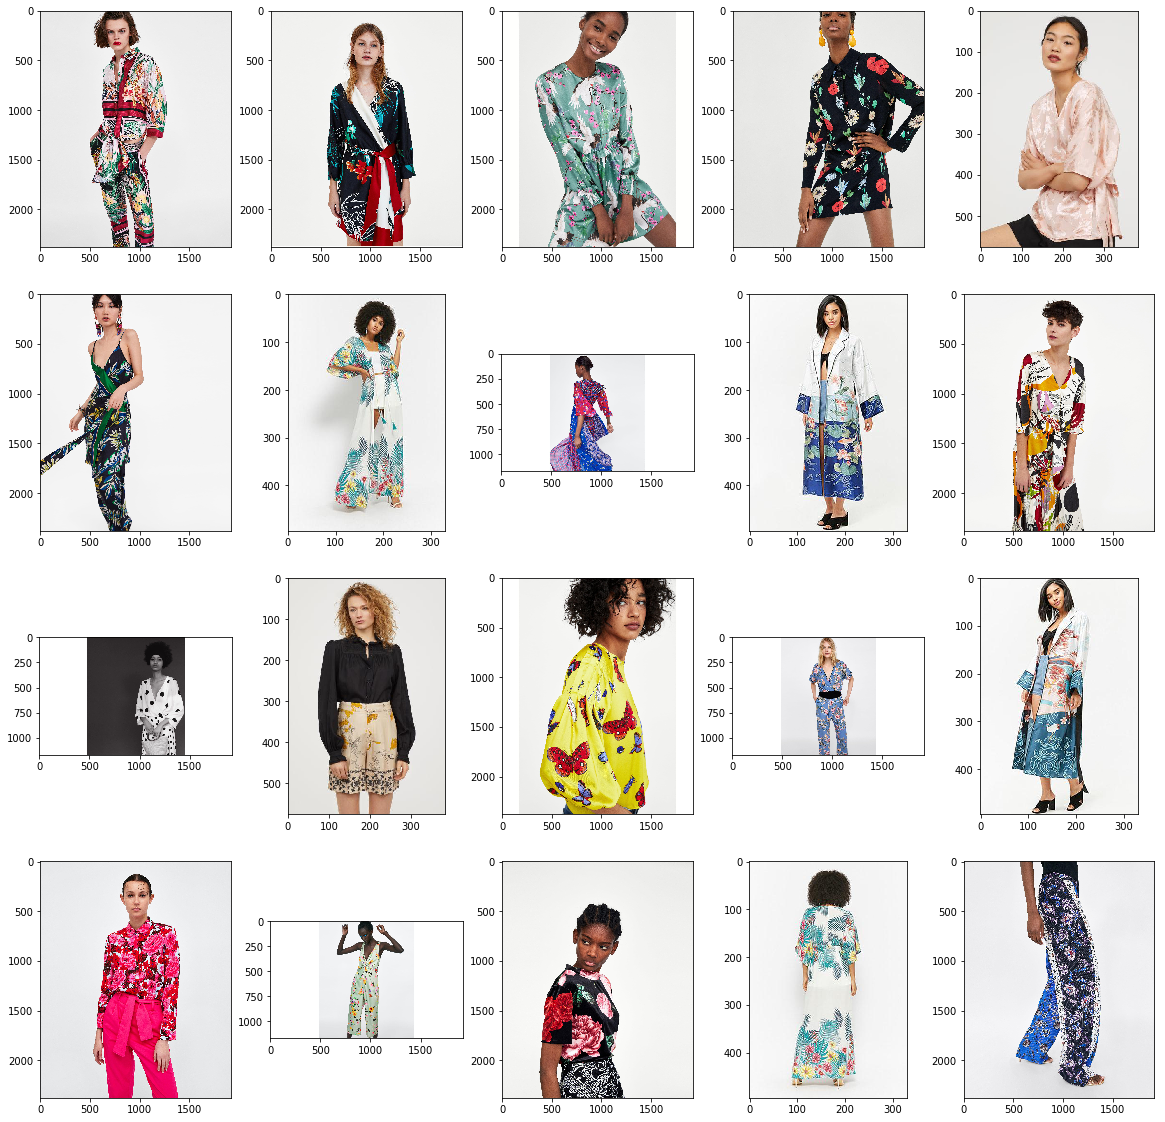

In [354]:
plt.imshow(img)

w=20
h=20
cols = 5
fig=plt.figure(figsize=(w, h))
for i, file_id in enumerate([str(int(f)) for f in list(image_ids[ind_auto][0])]):
    rec_img=mpimg.imread('all_products/' + file_id + ".jpg")
    sub_fig = fig.add_subplot(math.ceil(k/cols), cols, i+1)
    sub_fig.imshow(rec_img)

# Persist Models

In [350]:
from sklearn.externals import joblib
joblib.dump(tree_pca, "models/tree_pca.pkl")
joblib.dump(tree_auto, "models/tree_auto.pkl")
joblib.dump(principalComponents, "models/pca_transformer.pkl")
image_ids.dump('models/image_ids.pkl')